In [1]:
import torch
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('/Users/carlitos/Desktop/ProteinDesign/ProteinDesign/pdb_data_seq.csv')
protein_seq = df.query('macromoleculeType == "Protein"')['sequence']
print(protein_seq)
# we only need 20k protein sequences
protein_seq = protein_seq[:20000].reset_index(drop=True)
print(protein_seq)
# drop nan
protein_seq = protein_seq.dropna()
len(protein_seq)
# convert to list of protein sequences
proteins = protein_seq.tolist()
proteins[:3]

4         MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
7         MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
8         MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
11        MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...
12        MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
                                ...                        
467299    MNYQPTPEDRFTFGLWTVGWQGRDPFGDATRRALDPVESVQRLAEL...
467300    SVQATREDKFSFGLWTVGWQARDAFGDATRTALDPVEAVHKLAEIG...
467301    SVQATREDKFSFGLWTVGWQARDAFGDATRTALDPVEAVHKLAEIG...
467302    SVQATREDKFSFGLWTVGWQARDAFGDATRTALDPVEAVHKLAEIG...
467303    SVQATREDKFSFGLWTVGWQARDAFGDATRTALDPVEAVHKLAEIG...
Name: sequence, Length: 345180, dtype: object
0        MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
1        MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
2        MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
3        MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...
4        MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...

['MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRVKHLKTEAEMKASEDLKKHGVTVLTALGAILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGNFGADAQGAMNKALELFRKDIAAKYKELGYQG',
 'MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSELDKAIGRNTNGVITKDEAEKLFNQDVDAAVRGILRNAKLKPVYDSLDAVRRAALINMVFQMGETGVAGFTNSLRMLQQKRWDEAAVNLAKSRWYNQTPNRAKRVITTFRTGTWDAYKNL',
 'MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRFKHLKTEAEMKASEDLKKAGVTVLTALGAILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGNFGADAQGAMNKALELFRKDIAAKYKELGYQG']

In [3]:
# build a vocabulary of mapping the aa to integers
aa = list(set(''.join(proteins)))
stoi = {s:i+1 for i,s in enumerate(aa)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'P', 2: 'V', 3: 'U', 4: 'N', 5: 'R', 6: 'G', 7: 'M', 8: 'C', 9: 'F', 10: 'E', 11: 'L', 12: 'I', 13: 'D', 14: 'W', 15: 'Z', 16: 'K', 17: 'Q', 18: 'T', 19: 'H', 20: 'X', 21: 'S', 22: 'Y', 23: 'A', 0: '.'}
24


In [4]:
# let's build the dataset
block_size = 3 # context length

def build_dataset(proteins):
  X, Y = [], []

  for protein in proteins:
    #print(protein)
    context = [0] * block_size
    for aa in protein + '.':
      ix = stoi[aa]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(proteins)
n1 = int(0.8*len(proteins))
n2 = int(0.9*len(proteins))

Xtr, Ytr = build_dataset(proteins[:n1])      # 80%
Xdev, Ydev = build_dataset(proteins[n1:n2])  # 10%
Xte, Yte = build_dataset(proteins[n2:])      # 10%

torch.Size([3796221, 3]) torch.Size([3796221])
torch.Size([466658, 3]) torch.Size([466658])
torch.Size([482088, 3]) torch.Size([482088])


In [13]:
# -----------------------------------------------------------------------------------------------
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

In [14]:
torch.manual_seed(42); # seed rng for reproducibility

In [17]:
# original network
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

C = torch.randn((vocab_size, n_embd))
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
]

# parameter init
with torch.no_grad():
  layers[-1].weight *= 0.1 # last layer make less confident

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

11464


In [18]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb]
  x = emb.view(emb.shape[0], -1)
  for layer in layers:
      x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.1887
  10000/ 200000: 2.9320
  20000/ 200000: 2.8939
  30000/ 200000: 2.8707
  40000/ 200000: 2.9328
  50000/ 200000: 2.9210
  60000/ 200000: 2.8988
  70000/ 200000: 2.9833
  80000/ 200000: 2.8609
  90000/ 200000: 3.0043
 100000/ 200000: 2.9862
 110000/ 200000: 2.8614
 120000/ 200000: 3.0394
 130000/ 200000: 2.8654
 140000/ 200000: 2.9268
 150000/ 200000: 2.8455
 160000/ 200000: 2.9220
 170000/ 200000: 2.8522
 180000/ 200000: 3.1725
 190000/ 200000: 2.8344


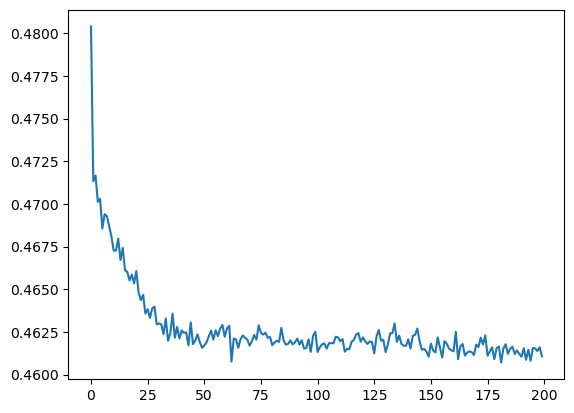

In [40]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [20]:
# put the layers into eval mode
for layer in layers:
  layer.training = False

In [21]:
# Evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.8945178985595703
val 2.8942127227783203


In [22]:
# sample from the model
for _ in range(3):

  out = []
  context = [0] * block_size
  while True:
    # forward pass of the neural net
    emb = C[torch.tensor([context])]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    logits = x
    probs = F.softmax(logits, dim=1)
    # sample from the distribution
    ix = torch.multinomial(probs, num_samples=1).item()
    # shift the context window and track the samples
    context = context[1:] + [ix]
    out.append(ix)
    # if we sample the special '.' token, break
    if ix == 0:
      break

  print(''.join(itos[i] for i in out)) # decode and print the generated protein

NGTGATAAVVLVRVVNMLKIAARDIIDMNNELNPSRNDYTDATCGTHGSSGEQGGWGLDSYGCDAEAGLRHTYETMAQKMGLDDADLVVAGVDMALLVATYWQAVVRGIPIVDNDALHLAWTAGKVVKSTTPDVVRNDVLYGTRLEPVAKSVEDLKAVNRIGANFPNLICGLSWAIEKMVLVEGNKQRALVDLSCTSPTVPYNPERFARVILRMSSDRAFYFSYSNSTLAKNVISTISAHQGWNYMGGERVQQSLKIGLKEFFQDEEGASQGCARDRRHLLGAKYKDMSEWARTYAGYVEANGKCYVKTLKDICLNENATYTDDPNQQKTNSALDDYLINAMMSNVTFVAGYRDTTLDPYKAAAQVSAVLVLEPWKVVVLPTNKGVFLVAKDLLIDPTHMTVVAENVGTGITSIIGAVYMAARTGFEDNAVFEMCAVLTSIDGDVNLHLLGAPDGTDLWELLPKGNFGKFITTEQDVVTGASAERLWSGDLQLAFAYSYDLFRLTLVAMAFGTDGFTHGIASPADVETLCLTFMDIMFHI.
XLPCTKEIIAENTATHTVLYSDSYPLSKSPKPEPQRFPDFPRTLRTSPSPNRQLHLEGEKEGFINKDQVLTRNHNHLLKQYLTNGVANIHKMEILAKVAASKNVTYPLEQALALRTSGISLIDRRYDDFNVVAETGGKEKAAAVPKGKHITVSASNPH.
DIESGVKSLELPSKMLVFELSRRAWDTAVRIDVTKMH.
